# Spread Prediction using Decision Tree

* Two version of modeling : Y=Spread(future) | Y=Direction of Spread(future)
* X1 : Past Spread
* X2 : Spread - Exponential Moving Average (short term direction)
* X3 : Standard Deviation of Spread (Volatility)
* X4 : Sum of two stocks' volumes (Volume Liquidity)
* X5 : Momentum (Spread - Spread-10daysAgo)


In [1]:
import logging, os, pickle
import requests, glob
from datetime import datetime
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import time
from datetime import date
import urllib.request
from selenium.webdriver import Chrome
import json, re, sys, h5py
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from pykrx import stock
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import numpy as np
import scipy.stats as stats
from scipy import stats
import matplotlib.font_manager as fm
import pyautogui
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
#import Loader

In [2]:
import sys
sys.path.append('C:\\Users\Bae Kyungmo\OneDrive\Desktop\StockTraidingAutomation\DataModeling')

In [3]:
#from DataModeling import Loader_v2
from Loader_v2 import Loader
ldr = Loader(pwd='t')

In [4]:
def Correlation_v3(log_pr, cutoff=0.05):
    rst = pd.DataFrame(columns=['corr','A','B'])
    codes = list(log_pr.columns)
    for i in range(len(codes)):
        for j in range(len(codes)):
            if i<j:
                corr, pvalue = stats.pearsonr(log_pr[codes[i]], log_pr[codes[j]])
                if pvalue <= cutoff and corr >= 0:
                    tmp = pd.DataFrame(columns=['corr','A','B'])
                    tmp.loc[0,'corr'] = corr
                    tmp.loc[0,'A'] = codes[i]
                    tmp.loc[0,'B'] = codes[j]
                    rst = pd.concat([rst, tmp])
    return rst.sort_values(by=['corr'],ascending=False).reset_index(drop=True)

In [5]:
def PartialCorrelation_v2(df, x,y,kospi):
    x = np.array(df[x]).reshape(-1,1)
    y = np.array(df[y]).reshape(-1,1)
    start = df.index[0]
    end = df.index[-1]
    #print(start, end)
    ksp = kospi[(kospi.index>=start)&(kospi.index<=end)]
    #ksp = kospi
    z = np.array(ksp['close']).reshape(-1,1)

    # Remove Market Factor by KOSPI
    reg1 = LinearRegression().fit(z, x)
    x_res = x - reg1.predict(z)
    reg2 = LinearRegression().fit(z, y)
    y_res = y - reg2.predict(z)

    corr, pvalue = stats.pearsonr(x_res.reshape(-1,), y_res.reshape(-1,))
    
    return corr, pvalue

In [6]:
def DiffCorrelation(rst, log_pr, cutoff=0.05):
    df = rst.copy()
    df.reset_index(drop=True, inplace=True)
    diff_corr = []
    for idx, row in df.iterrows():
        a = row.A
        b = row.B
        a_v = log_pr[a].diff(1).dropna(axis=0)
        b_v = log_pr[b].diff(1).dropna(axis=0)
        r, pv = stats.pearsonr(a_v, b_v)
        if pv <= cutoff and r >=0 :
            diff_corr.append(r)
        else :
            diff_corr.append(-999.9)
    df['dcorr'] = diff_corr
    return df[lambda x : x['dcorr']!=-999.9]

In [7]:
def ExpectedEarning_v2(a, b, eta, pr, enter=1, position='A'):
    with open("TradingDates.pickle", "rb") as fr:
        trading_dates = pickle.load(fr)
    pr = pr[[a,b]]
    log_pr = np.log(pr)
    spread = log_pr[a] - log_pr[b] * eta
    spread_df = pd.DataFrame(spread, columns=['spread'])
    if position=='A':
        invade = spread.mean() - enter*spread.std()
        invade_idx = list(spread_df[lambda x : x['spread'] <= invade].index)
        equib = spread.mean()
        equib_idx = list(spread_df[lambda x : x['spread'] >= equib].index)
        
        trade_idx = []
        flagInvade = True
        for idx, row in spread_df.iterrows():
            if flagInvade and row.spread <= invade :
                trade_idx.append(idx)
                flagInvade = False
            elif not flagInvade and row.spread >= equib :
                trade_idx.append(idx)
                flagInvade = True
                
    elif position=='B':
        invade = spread.mean() + enter*spread.std()
        invade_idx = list(spread_df[lambda x : x['spread'] >= invade].index)
        equib = spread.mean()
        equib_idx = list(spread_df[lambda x : x['spread'] <= equib].index)
        
        trade_idx = []
        flagInvade = True
        for idx, row in spread_df.iterrows():
            if flagInvade and row.spread >= invade :
                trade_idx.append(idx)
                flagInvade = False
            elif not flagInvade and row.spread <= equib :
                trade_idx.append(idx)
                flagInvade = True
    else :
        raise ValueError("Can't Be.")

    
    earnings = spread_df[spread_df.index.isin(trade_idx)].diff(1)
    earnings = earnings.iloc[[i*2+1 for i in range(0,int(len(earnings)/2))],:]
    earning_dates = list(earnings.index)
    max_term = 0
    for idx in range(len(earning_dates)):
        if idx != len(earning_dates)-1 :
            term = trading_dates.index(earning_dates[idx+1]) - trading_dates.index(earning_dates[idx])
            if max_term <= term:
                max_term = term
    
    trade_num = len(earnings)
    if position=='A':
        earnings = np.exp(((np.log(earnings+1)).cumsum().iloc[-1,0]) / trade_num)
    elif position=='B':
        earnings = np.exp(((np.log((earnings*(-1))+1)).cumsum().iloc[-1,0]) / trade_num)
    
    return earnings, trade_num, max_term

In [29]:
def TradeVisual_v2(A, B, eta, start, end, pwd,enter=1):
    font_path = r'C:\Users\Bae Kyungmo\Downloads\Nanumsquare_ac_TTF\Nanumsquare_ac_TTF\NanumSquare_acR.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=15)
    color=iter(cm.rainbow(np.linspace(0,1,3)))
    ldr = Loader(pwd=pwd)
    pr = ldr.GetPricelv2(start,end,[A,B])
    loglv22 = np.log(pr)
    qq_log = loglv22[(loglv22.index>=start)&(loglv22.index<=end)]
    qq_full = loglv22[(loglv22.index>=start)]
    aa = qq_log[A]
    bb = qq_log[B]
    aa_full = qq_full[A]
    bb_full = qq_full[B]
    etaa = eta
    spread = aa - bb * etaa
    spread_full = aa_full - bb_full * etaa
    fig = plt.figure(figsize=(12,10))
    ax1 = fig.add_subplot(2, 1, 1)
    plt.xticks(range(0,len(spread_full),30), [spread_full.index[idx] for idx in range(0,len(spread_full),30)])
    #plt.grid(True)
    try :
        A_name = ldr.FindNameByCode(A)
        B_name = ldr.FindNameByCode(B)
    except :
        if B == '005935':
            A_name = ldr.FindNameByCode(A)
            B_name = '삼성전자(우)'
        else:
            A_name = A
            B_name = B
    plt.title("PAIR TRADING : {} & {} with COINT-COEFF {}".format(A_name,B_name,etaa),fontproperties=fontprop)    
    ax2 = fig.add_subplot(2, 1, 2)
    ax1.plot(spread.reset_index().index, spread.values,color='black')
    ax1.plot(spread_full.reset_index().index[len(spread):], spread_full.values[len(spread):],color='black')
    ax1.hlines(spread.mean(),0,len(spread_full),colors='blue',linewidth=3,linestyles='dashed')
    ax1.hlines(spread.mean()+enter*spread.std(),0,len(spread_full),colors='skyblue',linewidth=2,linestyles='dashed')
    ax1.hlines(spread.mean()-enter*spread.std(),0,len(spread_full),colors='skyblue',linewidth=2,linestyles='dashed')
    ax1.hlines(spread.mean()+1*spread.std(),0,len(spread_full),colors='gray',linewidth=1,linestyles='dashed')
    ax1.hlines(spread.mean()-1*spread.std(),0,len(spread_full),colors='gray',linewidth=1,linestyles='dashed')
    ax1.vlines(len(spread),min(spread_full),max(spread_full),colors='purple',linewidth=2,linestyles='solid')
    plt.xticks(range(0,len(spread_full),30), [spread_full.index[idx] for idx in range(0,len(spread_full),30)])
    ax2.plot(spread_full.reset_index().index, pr[A],label=A)
    ax2.plot(spread_full.reset_index().index, pr[B],label=B)
    #ax2.plot(spread_full.reset_index().index, pr[A].rolling(5,1).mean(),label='{}_MA5'.format(A),color='skyblue')
    #ax2.plot(spread_full.reset_index().index, pr[B].rolling(5,1).mean(),label='{}_MA5'.format(B),color='gray')
    ax2.vlines(len(spread),-4,4,colors='purple',linewidth=2)
    ax2.legend(loc='upper left')
    #plt.grid(True)
    plt.show()
    return True

In [15]:
def PairTrading_v12(start, end, code_ls, pwd,cutoff=0.05, enter=1, pr_diff=20000):
    ldr = Loader(pwd=pwd)
    pr = ldr.GetPricelv2(start, end, code_ls)
    #pr = pr_df.copy()
    print("Initial number of companies : {}".format(len(pr.columns)))
    """ 0) Log PR """
    pr = pr.astype(float)
    pr = pr[(pr.index>=start)&(pr.index<=end)]
    pr = pr.dropna(axis=1,how='any')
    log_pr = np.log(pr)
    
    drop_ls = []
    for cd in log_pr.columns:
        if len(log_pr[cd].value_counts())==1:
            drop_ls.append(cd)
        elif log_pr[cd].value_counts().iloc[:2].sum() >= len(log_pr[cd]) * 0.3 :
            drop_ls.append(cd)
    print("Almost no change in price in this period -> removed : {}".format(len(drop_ls)))
    log_pr.drop(drop_ls, axis=1, inplace=True)
    pr.drop(drop_ls, axis=1, inplace=True)
    
    """ 1) Correlation """
    cor_rst = Correlation_v3(log_pr, cutoff)
    print("Validation w.r.t Correlation : {}".format(len(cor_rst)))
    
    """ 2) Partial Correlation """
    ksp = pd.read_hdf("../FullCache/KOSPI_lv2.h5")
    ksp = ksp[(ksp.index>=start)&(ksp.index<=end)]
    pcor_rst = pd.DataFrame(columns = ['A','B','corr','pcorr'])
    for idx in range(len(cor_rst)):
        a = cor_rst.loc[idx, 'A']
        b = cor_rst.loc[idx, 'B']
        pcor, ppvalue = PartialCorrelation_v2(log_pr, a, b, ksp)

        if ppvalue <= cutoff and pcor>=0:
            pcor_rst.loc[idx,'A'] = a
            pcor_rst.loc[idx,'B'] = b
            pcor_rst.loc[idx,'corr'] = cor_rst.loc[idx,'corr']
            pcor_rst.loc[idx,'pcorr'] = pcor
    pcor_rst.reset_index(drop=True,inplace=True)
    print("Validation w.r.t Partial-Correlation by KOSPI : {}".format(len(pcor_rst)))
        
    """ 3) CoIntegration & 4) Coeff Estimation """
    # Curious about negative cointeg coeff
    cointeg_rst = pd.DataFrame(columns = ['A','B','corr','pcorr','cointeg'])
    for idx in range(len(pcor_rst)):
        a = pcor_rst.loc[idx,'A']
        b = pcor_rst.loc[idx,'B']
        coint_result = coint(log_pr[a], log_pr[b])
        tmp_coeff, tmp_pvalue = coint_result[0], coint_result[1]
        if tmp_pvalue <= cutoff :
            min_pvalue = tmp_pvalue
            best_coeff = tmp_coeff
        else :
            continue
            min_pvalue = 1.0
            best_coeff = -999.9
        
        for eta in [0.1*i for i in range(5,21)]:
            spread = log_pr[a] - log_pr[b] * eta
            adfuller_rst = adfuller(spread)
            if adfuller_rst[1] <= cutoff:
                if adfuller_rst[1] < min_pvalue:
                    min_pvalue = adfuller_rst[1]
                    best_coeff = eta
                else :
                    pass
        if best_coeff != -999.9:
            cointeg_rst.loc[idx,'A'] = a
            cointeg_rst.loc[idx,'B'] = b
            cointeg_rst.loc[idx,'corr'] = pcor_rst.loc[idx,'corr']
            cointeg_rst.loc[idx,'pcorr'] = pcor_rst.loc[idx,'pcorr']
            cointeg_rst.loc[idx,'cointeg'] = best_coeff
    cointeg_rst.reset_index(drop=True, inplace=True)
    print("Validation w.r.t CoIntegration : {}".format(len(cointeg_rst)))
#     for idx, row in cointeg_rst.iterrows():
#         print(row.A, row.B, row.cointeg)
    
    """ 5) Spread Estimation """
    # 6) no need to check trend since we did stationarity trend test
    valid_idx = []
    for idx in range(len(cointeg_rst)):
        a = cointeg_rst.loc[idx,'A']
        b = cointeg_rst.loc[idx,'B']
        coint_coeff = cointeg_rst.loc[idx,'cointeg']
        spread = log_pr[a] - log_pr[b] * coint_coeff
        
        """ 7) Normality """
        if stats.shapiro(spread)[1] >= cutoff :
            """ 8) Stationarity """
            if adfuller(spread)[1] <= cutoff :
                valid_idx.append(idx)
    pairs = cointeg_rst[cointeg_rst.index.isin(valid_idx)]
    pairs.reset_index(drop=True, inplace=True)
    print("Validation w.r.t Normality & Stationarity : {}".format(len(pairs)))
    
    
    """ 9) Risk & 10) Earnings with the number of trade"""
    risk_ls = []
    A_earning_ls = []
    A_trade_ls = []
    A_maxterm_ls = []
    B_earning_ls = []
    B_trade_ls = []
    B_maxterm_ls = []
    
    for idx in range(len(pairs)):
        a = pairs.loc[idx,'A']
        b = pairs.loc[idx,'B']
        coint_coeff = pairs.loc[idx,'cointeg']
        spread = log_pr[a] - log_pr[b] * coint_coeff
        risk_ls.append(spread.diff().std())
        try :
            earning, trade_num, max_term = ExpectedEarning_v2(a, b, coint_coeff, pr, enter=enter, position='A')
            A_earning_ls.append((earning-1)*100)
            A_trade_ls.append(trade_num)
            A_maxterm_ls.append(max_term)
        except :
            A_earning_ls.append(-999)
            A_trade_ls.append(-999)
            A_maxterm_ls.append(-999)
        try:
            earning, trade_num, max_term = ExpectedEarning_v2(a, b, coint_coeff, pr, enter=enter, position='B')
            B_earning_ls.append((earning-1)*100)
            B_trade_ls.append(trade_num)
            B_maxterm_ls.append(max_term)
        except:
            B_earning_ls.append(-999)
            B_trade_ls.append(-999)
            B_maxterm_ls.append(-999)

        
    pairs['risk'] = risk_ls
    pairs['A_earnings(%)'] = A_earning_ls
    pairs['A_trade#'] = A_trade_ls
    pairs['A_maxterm'] = A_maxterm_ls
    pairs['B_earnings(%)'] = B_earning_ls
    pairs['B_trade#'] = B_trade_ls
    pairs['B_maxterm'] = B_maxterm_ls

    print("Adding Risk & Earnings & #Trade & #UpCut")
    """ 11) Difference Correlation """
    pairs = DiffCorrelation(pairs, log_pr, cutoff=cutoff)
    print("Validation w.r.t Diff-Correlation : {}".format(len(pairs)))
    """ 12) Add AvgVol & AvgMCPRate """
    #pairs = AddVolMcp(pairs).sort_values(by=['cointeg'],ascending=False).reset_index(drop=True)
    A_price=[]
    B_price=[]
    pr_valid=[]
    for idx, row in pairs.iterrows():
        A = row.A
        B = row.B
        A_price.append(pr.loc[pr.index[-1],A])
        B_price.append(pr.loc[pr.index[-1],B])
        if abs(pr.loc[pr.index[-5:],A].mean() - row.cointeg * pr.loc[pr.index[-5:],B].mean()) <= pr_diff:
            pr_valid.append('Y')
        else :
            pr_valid.append('N')
        
    pairs['A_price'] = A_price
    pairs['B_price'] = B_price
    pairs['PR_VALID'] = pr_valid
    #pairs = pairs[pairs.index.isin(pr_valid)].reset_index(drop=True)
        
    return pairs

In [26]:
%%time
start = '2020-04-01'
end = '2021-03-05'
code_ls = ['005930','005935']
rst2 = PairTrading_v12(start, end, code_ls, pwd='tlqkfdk2')

Initial number of companies : 2
Almost no change in price in this period -> removed : 0
Validation w.r.t Correlation : 1
Validation w.r.t Partial-Correlation by KOSPI : 1
Validation w.r.t CoIntegration : 1
Validation w.r.t Normality & Stationarity : 1
Adding Risk & Earnings & #Trade & #UpCut
Validation w.r.t Diff-Correlation : 1
Wall time: 585 ms


In [27]:
rst2

,A,B,corr,pcorr,cointeg,risk,A_earnings(%),A_trade#,A_maxterm,B_earnings(%),B_trade#,B_maxterm,dcorr,A_price,B_price,PR_VALID
0,005930,005935,0.994411,0.822789,0.9,0.009499,-999,-999,-999,-999,-999,-999,0.863283,82100.0,72200.0,Y


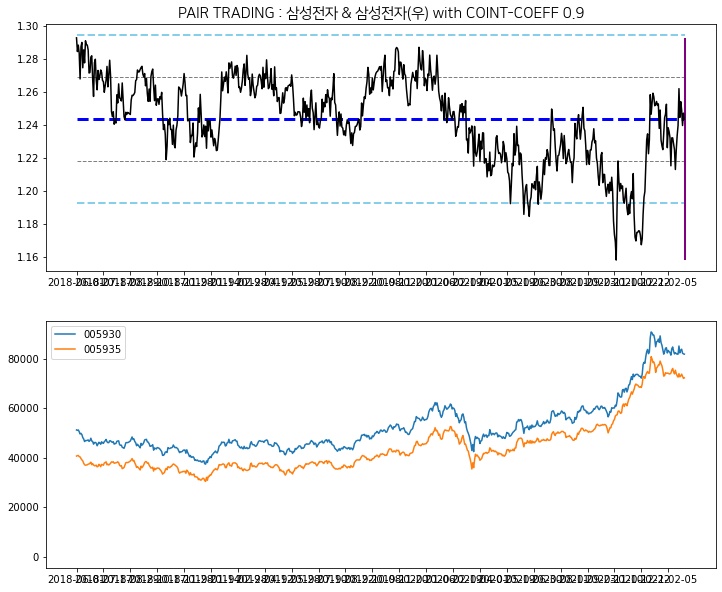

True

In [69]:
TradeVisual_v2('005930','005935',0.9, '2018-06-01','2021-03-31','tlqkfdk2', 2)

In [52]:
def SpreadValues(code1, code2, eta, start, end):
    pr = ldr.GetPricelv2(start, end, [code1,code2])
    log_pr = np.log(pr)
    spread = pd.DataFrame((log_pr[code1] - log_pr[code2] * eta),columns=['spread'])
    return spread

In [44]:
spread = SpreadValues('005930','005935',0.9,'2020-04-01','2021-03-04')

In [53]:
def SpreadDirection(code1, code2, eta, start, end, ndays=5):
    tdays = ldr.GetTradingDays(end=end)
    start_idx = tdays.index(start)
    past_date = tdays[start_idx-ndays]
    spread = SpreadValues(code1, code2, eta, past_date, end)
    spread_dir = spread - spread.ewm(ndays, min_periods=1).mean()
    spread_dir = spread_dir[spread_dir.index>=start]
    spread_dir.columns=['DIR']
    return spread_dir

In [80]:
SpreadDirection('005930','005935',0.9,'2020-04-01','2021-03-04').head(2)

,DIR
2020-04-01,-0.007193
2020-04-02,0.004015


In [54]:
def SpreadSTD(code1, code2, eta, start, end, ndays=5):
    tdays = ldr.GetTradingDays(end=end)
    start_idx = tdays.index(start)
    past_date = tdays[start_idx-ndays]
    spread = SpreadValues(code1, code2, eta, past_date, end)
    spread_STD = spread.rolling(ndays, min_periods=1).std()
    spread_STD = spread_STD[spread_STD.index>=start]
    spread_STD.columns=['STD']
    return spread_STD

In [81]:
SpreadSTD('005930','005935',0.9,'2020-04-01','2021-03-04').head(2)

,STD
2020-04-01,0.006566
2020-04-02,0.006408


In [55]:
def SpreadVolume(code1, code2, start, end):
    vol_lv1 = ldr.GetPricelv1(start,end,[code1,code2])
    dates = ldr.GetTradingDays(start,end)
    vol_df = pd.DataFrame(index=dates, columns=['SUMVOL'])
    for dt in dates :
        vol_df.loc[dt,'SUMVOL'] = vol_lv1[(vol_lv1.DATE==dt)&(vol_lv1.CODE.isin([code1,code2]))].volume.sum()
    return vol_df

In [106]:
SpreadVolume('005930','005935','2020-04-01','2021-03-04').head(2)

,SUMVOL
2020-04-01,29948488
2020-04-02,23624557


In [56]:
def SpreadMomentum(code1, code2, eta, start, end, diff_day=10):
    tdays = ldr.GetTradingDays(end=end)
    start_idx = tdays.index(start)
    past_date = tdays[start_idx-diff_day]
    spread = SpreadValues(code1, code2, eta, past_date, end)
    spread_diff = spread.diff(diff_day)
    spread_diff = spread_diff[spread_diff.index>=start]
    spread_diff.columns=['Momentum']
    return spread_diff

In [116]:
SpreadMomentum('005930','005935',0.9,'2020-04-01','2021-03-04',10).head(2)

,Momentum
2020-04-01,-0.019002
2020-04-02,-0.009232


In [57]:
def Visual_v2(code1, code2, eta, start, end):
    font_path = r'C:\Users\Bae Kyungmo\Downloads\Nanumsquare_ac_TTF\Nanumsquare_ac_TTF\NanumSquare_acR.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=15)
    color=iter(cm.rainbow(np.linspace(0,1,3)))
    
    spread = SpreadValues(code1,code2,eta,start,end)
    spread_dir = SpreadDirection(code1,code2,eta,start,end)
    spread_STD = SpreadSTD(code1,code2,eta,start,end)
    spread_VOL = SpreadVolume(code1,code2,start,end)
    spread_MOM = SpreadMomentum(code1,code2,eta,start,end)
    
    fig = plt.figure(figsize=(16,16))
    ax1 = fig.add_subplot(6, 1, 1)
    plt.xticks(range(0,len(spread),30), [spread.index[idx] for idx in range(0,len(spread),30)])
    ax1.plot(spread.reset_index().index, spread.values,color='black', label='Spread')
    ax1.legend(loc='upper left')

    ax2 = fig.add_subplot(6, 1, 2)
    plt.xticks(range(0,len(spread),30), [spread.index[idx] for idx in range(0,len(spread),30)])
    ax2.plot(spread_dir.reset_index().index, spread_dir, color='blue' ,label='SpreadDirection')
    ax2.legend(loc='upper left')
    
    ax3 = fig.add_subplot(6, 1, 3)
    plt.xticks(range(0,len(spread),30), [spread.index[idx] for idx in range(0,len(spread),30)])
    ax3.plot(spread_STD.reset_index().index, spread_STD, color='red',label='SpreadSTD')
    ax3.legend(loc='upper left')
    
    ax4 = fig.add_subplot(6, 1, 4)
    plt.xticks(range(0,len(spread),30), [spread.index[idx] for idx in range(0,len(spread),30)])
    ax4.plot(spread_VOL.reset_index().index, spread_VOL, color='magenta',label='SpreadVOL')
    ax4.legend(loc='upper left')
    
    ax5 = fig.add_subplot(6, 1, 5)
    plt.xticks(range(0,len(spread),30), [spread.index[idx] for idx in range(0,len(spread),30)])
    ax5.plot(spread_MOM.reset_index().index, spread_MOM, color='purple', label='SpreadMomentum')
    ax5.legend(loc='upper left')
    
#     ax6 = fig.add_subplot(6, 1, 6)
#     plt.xticks(range(0,len(spread),30), [spread.index[idx] for idx in range(0,len(spread),30)])
#     ax6.plot(spread.reset_index().index, spread.values,color='black', label='Spread')
#     ax6.plot(spread_dir.reset_index().index, spread_dir, color='blue' ,label='SpreadDirection')
#     ax6.plot(spread_STD.reset_index().index, spread_STD, color='red',label='SpreadSTD')
#     ax6.plot(spread_VOL.reset_index().index, spread_VOL, color='magenta',label='SpreadVOL')
#     ax6.plot(spread_MOM.reset_index().index, spread_MOM, color='purple', label='SpreadMomentum')
#     ax6.legend(loc='upper left')
    
    plt.show()
    return True

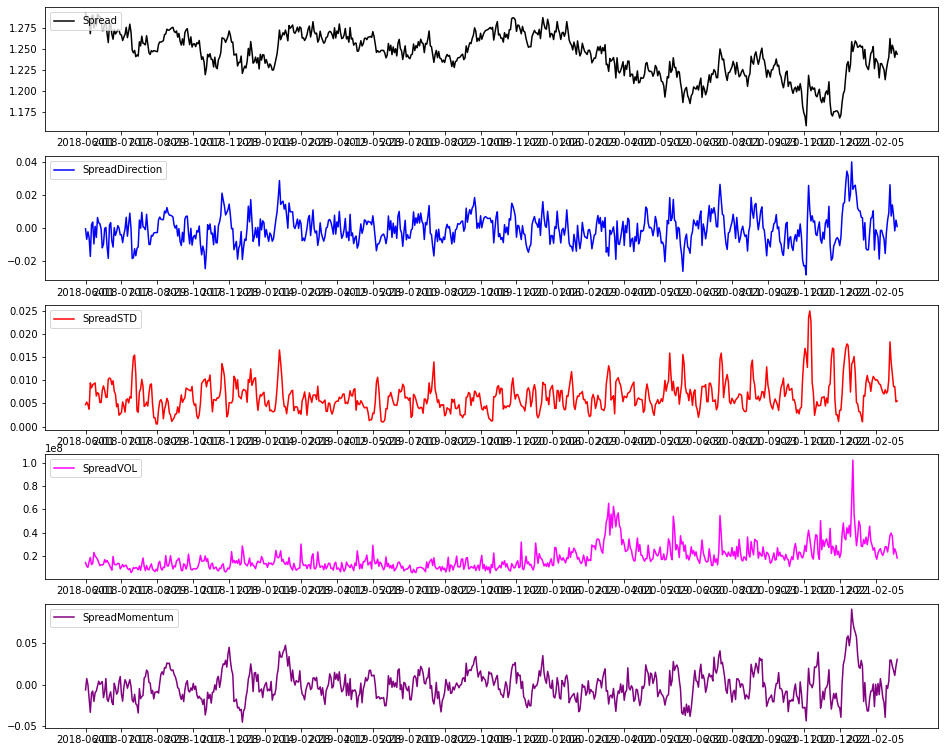

True

In [70]:
Visual_v2('005930','005935',0.9,'2018-06-01','2021-03-08')

In [197]:
%%time
code1 = '005930'
code2 = '005935'
eta = 0.9
start = '2018-06-01'
end = '2021-03-05'
spread = SpreadValues(code1,code2,eta,start,end)
spread_dir = SpreadDirection(code1,code2,eta,start,end)
spread_STD = SpreadSTD(code1,code2,eta,start,end)
spread_VOL = SpreadVolume(code1,code2,start,end)
spread_MOM = SpreadMomentum(code1,code2,eta,start,end)
pr = ldr.GetPricelv2(start,end,[code1])
ksp = ldr.GetKOSPI(start,end)

Xs = pd.concat([spread,spread_dir,spread_STD,spread_VOL,ksp],axis=1)
Y = SpreadSign(start, end, code1, code2, eta)

Wall time: 4.27 s


In [196]:
Xs=pd.concat([spread_dir,spread_STD,spread_VOL,pr,ksp],axis=1)
Y =spread.copy()

In [136]:
pd.concat([Xs,Y],axis=1).corr()

,DIR,STD,005930,KOSPI,spread
DIR,1.000000,0.065598,0.173880,0.175280,0.347835
STD,0.065598,1.000000,0.268200,0.226743,-0.214958
005930,0.173880,0.268200,1.000000,0.850248,-0.332049
KOSPI,0.175280,0.226743,0.850248,1.000000,-0.148664
spread,0.347835,-0.214958,-0.332049,-0.148664,1.000000


In [219]:
def SpreadSign(start, end, code1, code2, eta, raw=False):
    tdays = ldr.GetTradingDays()
    end_idx = tdays.index(end)
    next_day = tdays[end_idx+1]
    spd = SpreadValues(code1, code2, eta, start, next_day)
    spd_raw = spd.diff(1).shift(-1).iloc[:-1,:]
    diff_raw = spd_raw.copy()
    f = lambda x : 1 if x>=0 else 0
    spd_raw['spread'] = spd_raw['spread'].map(f)
    if raw :
        return spd_raw, diff_raw
    else :
        return spd_raw

In [151]:
SpreadSign('2018-06-01','2021-03-05','005930','005935',0.9).head(3)

,spread
2018-06-01,0
2018-06-04,1
2018-06-05,0


In [198]:
Xs.shape, Y.shape

((678, 5), (678, 1))

In [185]:
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from IPython import display
import pydotplus

In [199]:
X_train = Xs[Xs.index<='2020-11-31']
X_test = Xs[Xs.index>'2020-11-31']
Y_train = Y[Y.index<='2020-11-31']
Y_test = Y[Y.index>'2020-11-31']

In [200]:
dtc = DecisionTreeClassifier()

In [201]:
dtc.fit(X_train,Y_train)

DecisionTreeClassifier()

In [202]:
dtc.score(X_test,Y_test)

0.5079365079365079

In [203]:
pred = dtc.predict(X_test)

In [204]:
(pred == Y_test.values).mean()

0.4968505920886873

### It seems like no prediction power at all

In [205]:
export_graphviz(dtc, out_file='tree.dot')

In [206]:
dt_dot_data = tree.export_graphviz(dtc,out_file=None,feature_names=list(Xs.columns),
                    class_names=['Plus','Minus'],filled=True,max_depth=3,
                    rounded=True,special_characters=True)

In [207]:
dt_graph = pydotplus.graph_from_dot_data(dt_dot_data)

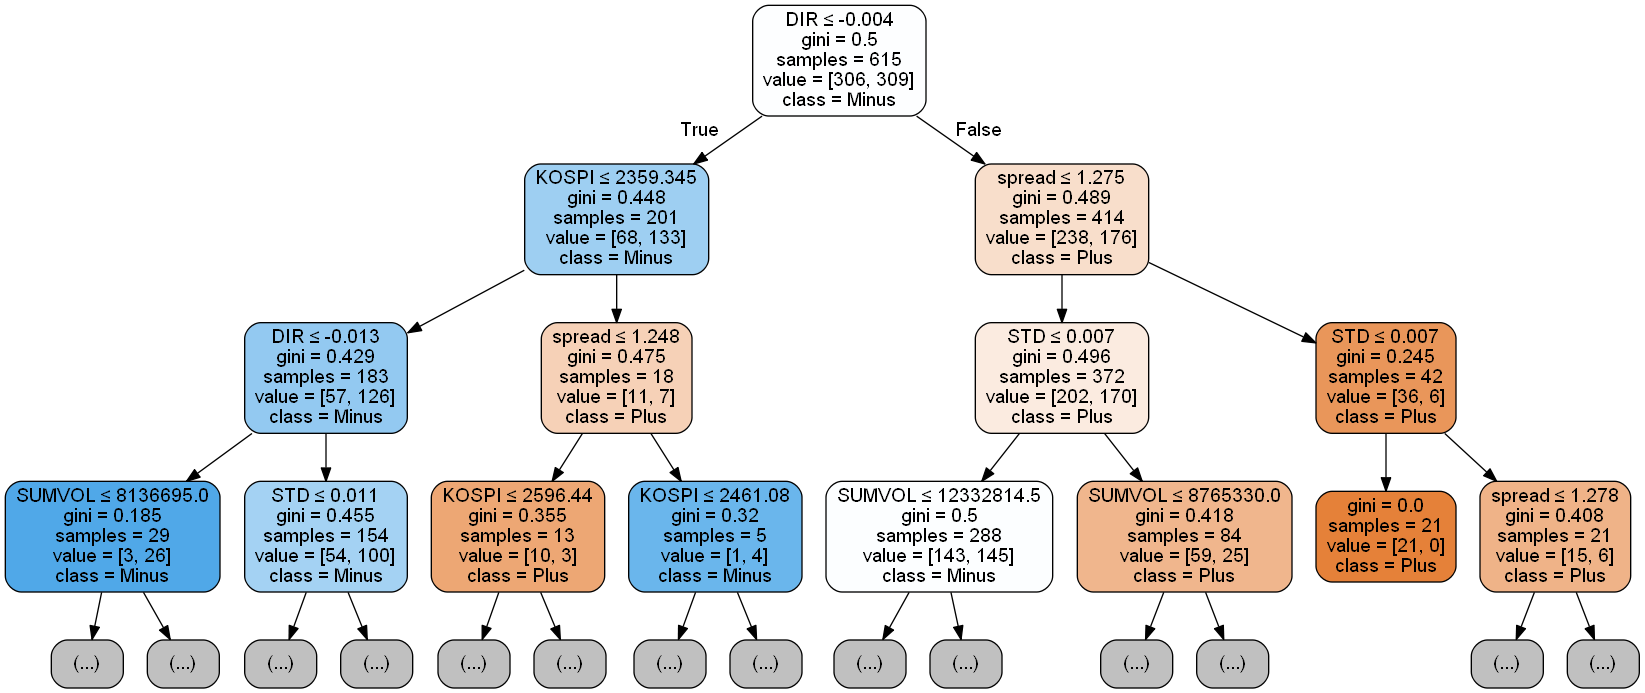

In [208]:
Image(dt_graph.create_png())

In [220]:
_, spd_diff = SpreadSign('2018-06-01','2021-03-05','005930','005935',0.9,True)

In [234]:
len((np.sign(spd_diff.rolling(5,1).mean().shift(1) * (-1)) - np.sign(spd_diff))[lambda x : x['spread']==0])

393

In [235]:
len(spd_diff)

678

In [236]:
393/678

0.5796460176991151

##### 5days Moving Average Reversion is more predictable...

<AxesSubplot:>

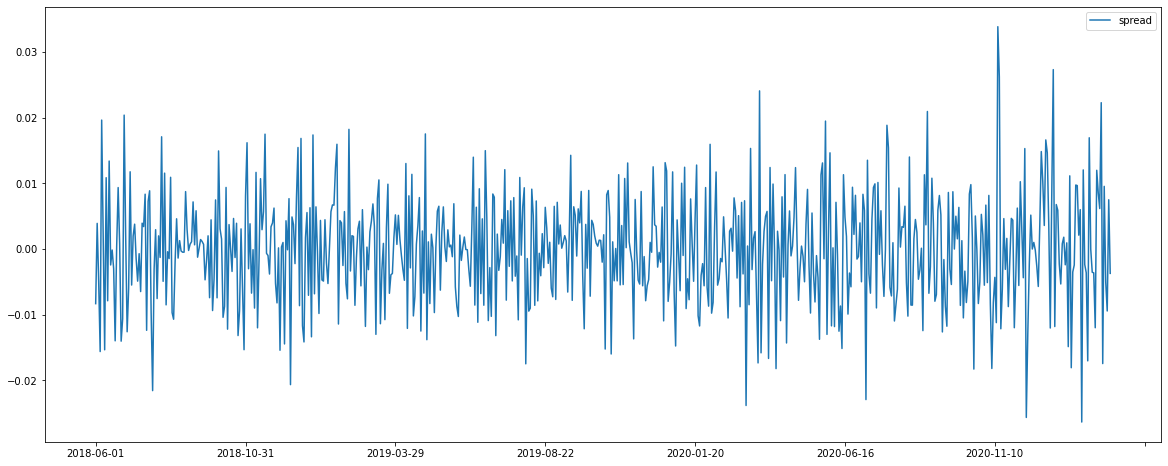

In [241]:
spd_diff.plot(figsize=(20,8))

In [239]:
stats.shapiro(spd_diff)

ShapiroResult(statistic=0.9973723888397217, pvalue=0.35568296909332275)

array([[<AxesSubplot:title={'center':'spread'}>]], dtype=object)

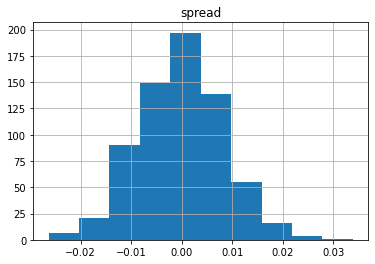

In [240]:
spd_diff.hist()

##### 어쩌면 당연한건가 Normality를 만족하는 spread만 찾은거니까..

<AxesSubplot:>

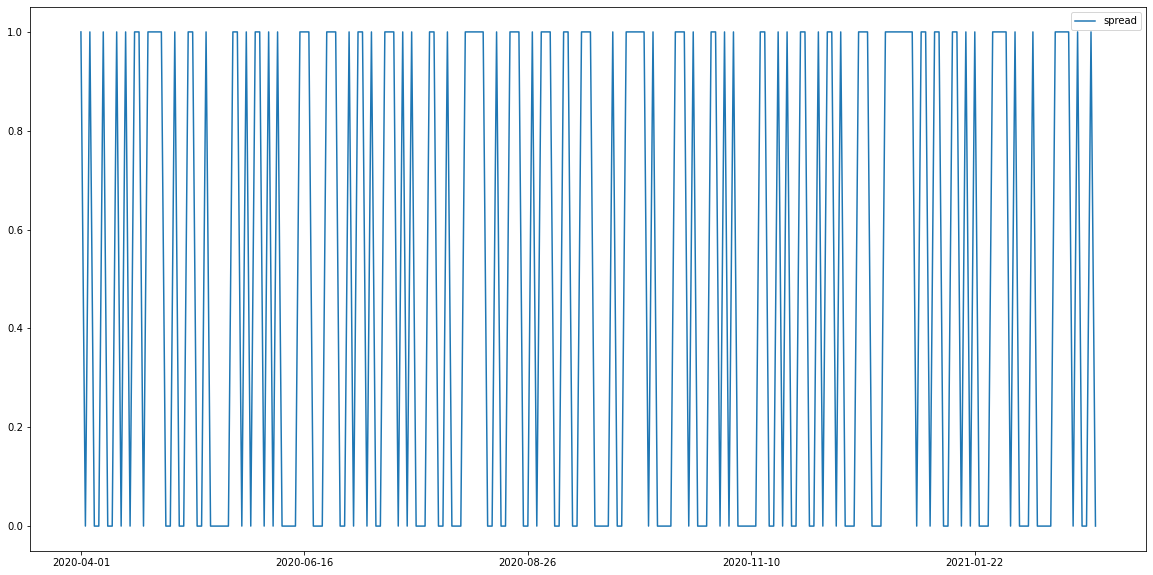

In [252]:
_[_.index>='2020-04-01'].plot(figsize=(20,10))